# Score Matching on a Toy Example

The purpose of this notebook is to implement from scratch the score matching objectives from the following papers:

[1] A. Hyvärinen. Estimation of non-normalized statistical models by score matching. Journal of Machine Learning Research 6.24 (2005), 695–709.  
[2] Y. Song, S. Garg, J. Shi, and S. Ermon. Sliced score matching: A scalable approach to density and score estimation (2019). <https://arxiv.org/abs/1905.07088>  
[3] P. Vincent. A connection between score matching and denoising autoencoders. Neural Computation 23.7 (2011), 1661-1674.  
[4] T. Karras, M. Aittala, T. Aila, S. Laine. Elucidating the design space of diffusion-based generative models. NeurIPS 2022 (2022), <https://arxiv.org/abs/2206.00364>

The objectives are implemented in PyTorch, and they are tested on a toy example of a multivariate normal distribution.

## Imports, Plotting code, and Training Code

In [1]:
import numpy as np
import torch
import torch.nn as nn

import matplotlib.pyplot as plt

In [2]:
def create_mesh_grid(rectangle_bounds, N_points=50):
    """Given rectangular bounds (x_1, y_1), ..., (x_n, y_n) create points in a
    mesh grid in this n-dimensional hypercube with N_points per axis."""

    linspaces = [torch.linspace(min_val, max_val, N_points) for min_val, max_val in rectangle_bounds]
    mesh_grid = torch.meshgrid(*linspaces, indexing="ij")
    grid_points = torch.stack([g.reshape(-1) for g in mesh_grid], dim=-1)
    return grid_points

def normalize_vectors(vectors):
    """Normalize the given vectors to have norm 1."""
    
    if torch.is_tensor(vectors):
        vectors = vectors.cpu().detach().numpy()

    norms = np.linalg.norm(vectors, axis=1, keepdims=True)
    return vectors / (norms + 1e-9)

def plot_vector_field(points, vectors):
    """Plot a 2D vector field."""

    assert len(points.shape) == 2

    normalized_vectors = normalize_vectors(vectors)
    fig, ax = plt.subplots()
    ax.scatter(points[:,0], points[:,1], alpha=0.0, edgecolors="white")
    ax.quiver(points[:,0], points[:,1], normalized_vectors[:,0], normalized_vectors[:,1], width=0.002)
    return fig, ax

class ScoreModel:
    def __init__(self, model):
        self.model = model
    def __call__(self, X):
        return self.model(X)
    def loss(self, X):
        raise NotImplementedError()

In [3]:
def train(score_model, loader, N_epochs, lr=0.001, device=None):
    score_model.model = score_model.model.to(device)

    optimizer = torch.optim.Adam(score_model.model.parameters(), lr=lr)
    best_loss = float("inf")
    
    # Observe that the losses are often just indicative as some losses are
    # stochastic.

    for epoch in range(N_epochs):
        for batch in loader:
            X = batch.to(device)
            loss = score_model.loss(X)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            observed_loss = loss.item()
            if observed_loss < best_loss:
                best_loss = observed_loss
        print("Epoch {}, loss: {}".format(epoch + 1, observed_loss))
    
    print()
    print("Best loss: {}".format(best_loss))

## Explicit Score Matching (ESM)

In [4]:
def compute_jacobian(model, batch):
    """Computes the Jacobian for the given function evaluated at the points in
    the batch. We assume that the inputs to the model are elements of R^n,
    so we accept batches of shape [b, n] and [n]. The return shape is always of
    the form [b, m, n] where m is the number of input variables."""
    
    assert len(batch.shape) <= 2
    if len(batch.shape) == 1:
        batch = torch.unsqueeze(batch, 0)
    
    jacobian = torch.vmap(torch.func.jacrev(model))(batch)
    return jacobian.squeeze(1, 2)

class ESM(ScoreModel):
    def loss(self, X):
        """Computes the score model loss for the explicit score matching [1]
        for the batch X."""

        # TODO: This is not the most efficient as computing the Jacobian
        # requires computing model(X) and then we recompute it.
        jacobian = compute_jacobian(self.model, X)
        trace = torch.vmap(torch.trace)(jacobian)
        norm_squared = 0.5*self.model(X).pow(2).sum(dim=1)
        loss = (trace + norm_squared).mean()
        return loss

## Sliced Score Matching (SSM)

In [5]:
class SSM(ScoreModel):
    def __init__(self, model, M=1):
        super().__init__(model)
        self.M = M

    def loss(self, X):
        """Computes the score model loss for the sliced score matching [2] for
        the batch X. As the random vector distribution, we use an appropriate
        multivariate normal distribution, which satisfies the assumptions of
        [2]. The number M controls how many random vectors per true data sample
        are used. The default is M=1, which is suggeested to be enough in
        [2]."""
        
        # TODO: This is not strictly as in [2] as the vectors change. To fix this
        # easily, uncomment the next line.
        #torch.manual_seed(0)

        loss_components = []
        for _ in range(self.M):
            # Sample random vectors to be multiplied with all Jacobians. One
            # vector is sampled for each Jacobian.
            v = torch.randn_like(X)
            # Get model output Y with the inputs X and the corresponding
            # Jacobian-vector products. The function jvp returns the
            # matrix-vector product transposed, so we need to multiply jv with
            # v from the right.
            Y, jv = torch.autograd.functional.jvp(self.model, X, v, create_graph=True)
            vjv = torch.bmm(jv.unsqueeze(1), v.unsqueeze(2))
            vY = torch.bmm(v.unsqueeze(1), Y.unsqueeze(2))
            loss_components.append( (1/X.shape[0]) * (vjv.sum() + 0.5*vY.pow(2).sum()) )
        loss = torch.stack(loss_components).mean()
        
        return loss

## Denoising Score Matching (DSM)

In [6]:
class DSM(ScoreModel):
    def __init__(self, model, sigma=0.01):
        super().__init__(model)
        self.sigma = sigma
    
    def loss(self, X):
        """Computes the score model loss for the denoised score matching [3]
        for the batch X. Here we implement the loss which involves only the
        gradient of the logarithm of the Parzen kernel, not the version where
        the full Parzen estimate is used. We use gaussian Parzen kernel."""
        
        # Notice that this method is sensitive to selecting the correct sigma!
        
        # The loss is an expectation over a joint distribution where the
        # conditional part is normal noise from N(0, 1/sigma^2 I) added to the
        # true data distribution and the unconditional part is the true data
        # distribution.
        Y = X + self.sigma * torch.randn_like(X)
        score_model_part = self.model(Y)
        glp_part = (1/self.sigma**2) * (X - Y)
        loss = 0.5 * (score_model_part - glp_part).pow(2).sum(dim=1).mean()
        return loss

# Score Matching via Noise Estimator

In [7]:
class NE(ScoreModel):
    def __init__(self, model, sigma=0.01, M=5):
        super().__init__(model)
        self.sigma = sigma # Specifies the noise N(0, \sigma^2 I) to be added.
        self.M = M # How many noise samples per data sample in the loss.
    
    def __call__(self, X):
        return (self.model(X) - X)/self.sigma**2
    
    def loss(self, X):
        """Computes the mean square loss of [4] with the aim to train a
        denoiser that can be used to compute the score as above."""

        # We do the loops in this order to ensure that different data points
        # get different noises.
        # TODO: This seems slower than it needs to be.
        loss_per_data = torch.zeros(X.shape[0])
        for i in range(X.shape[0]):
            # Get M samples of noise from N(0, \sigma^2 I).
            Z = torch.randn((self.M, *X.shape[1:], ))
            Z = Z.to(X.device)
            # Squared norms of the reconstruction errors by the model.
            RE = (self.model(X[i] + Z) - X[i]).pow(2).sum(dim=tuple(range(1, Z.ndimension())))
            # Mean squared error of reconstruction loss.
            loss_per_data[i] = RE.mean()
        
        return loss_per_data.mean()

## The Toy Example

### Define the Distribution Whose Score We Aim to Learn

In [8]:
# Define a 2D gaussian with independent components having same variance.
mu = torch.tensor([7.5130, 9.0259])
sigma = np.sqrt(1.3975)
input_dim = mu.shape[0]
cov =  sigma**2 * torch.eye(input_dim)
mvn = torch.distributions.MultivariateNormal(mu, cov)

def gradient(X):
    """The gradient field for the gaussian."""
    return (1/sigma**2) * (mu - X)

### Plot the True Gradient Field

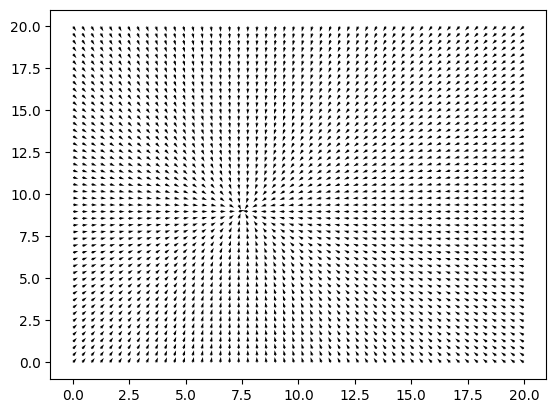

In [9]:
bounds = [[0, 20], [0, 20]]
grid_points = create_mesh_grid(bounds)
gradients = gradient(grid_points)
plot_vector_field(grid_points, gradients);

### Train the Model

In [10]:
# Define a very simple model to be used in the score.
model = nn.Sequential(
    nn.Linear(input_dim, 128), nn.SiLU(),
    nn.Linear(128, 128), nn.SiLU(),
    nn.Linear(128, input_dim)
)
device = "cuda" # or None
model = model.to(device)

In [11]:
# Select how we model the score and set up training.
score_model = ESM(model)
#score_model = SSM(model, M=1)
# DSM requires more epochs to have good quality, it's also sensitive to setting sigma right.
#score_model = DSM(model, sigma=0.1)
#score_model = NE(model, sigma=0.1, M=5)

N_epochs = 10
lr = 0.0001

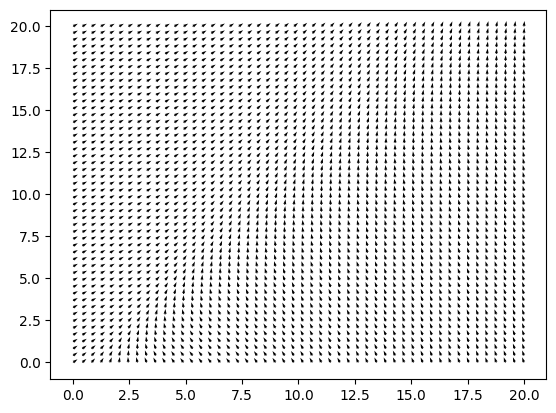

In [12]:
# Plot the gradient of the untrained model.
gradients = score_model(grid_points.to(device)).squeeze(1).cpu().detach().numpy()
plot_vector_field(grid_points, gradients);

In [13]:
# Obtain training data and set up a training data loader.
N_samples = 10000
data = mvn.sample((N_samples, ))
training_data_loader = torch.utils.data.DataLoader(data, batch_size=32, shuffle=True)

In [14]:
# Train the score model.
train(score_model, training_data_loader, N_epochs=N_epochs, lr=lr, device=device)

Epoch 1, loss: -0.6335103511810303
Epoch 2, loss: -0.5469810962677002
Epoch 3, loss: -0.7341489791870117
Epoch 4, loss: -0.6267768144607544
Epoch 5, loss: -0.9148663282394409
Epoch 6, loss: -0.26703330874443054
Epoch 7, loss: -0.7987748980522156
Epoch 8, loss: -0.7529219388961792
Epoch 9, loss: -0.6057041883468628
Epoch 10, loss: -0.7871434688568115

Best loss: -1.0916366577148438


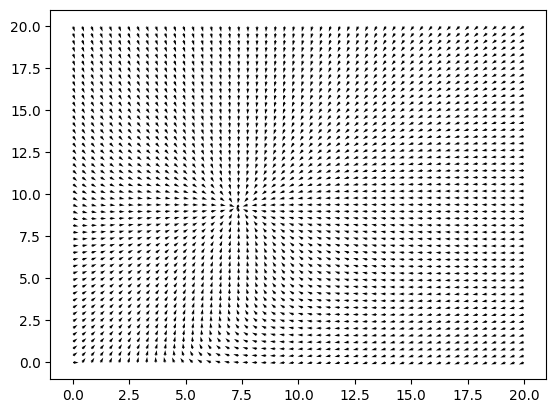

In [15]:
# Plot the gradient of the trained model.
gradients = score_model(grid_points.to(device)).squeeze(1).cpu().detach().numpy()
plot_vector_field(grid_points, gradients);

## Gradient Ascent

In [16]:
def plot_point(X, ax, previous=None):
    Y = X.detach().cpu()
    ax.scatter(*Y, s=10, color="r")
    if previous is not None:
        Z = previous.detach().cpu()
        ax.arrow(*Z, Y[0] - Z[0], Y[1] - Z[1])

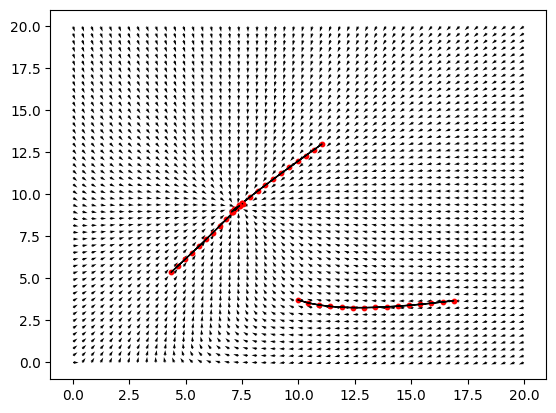

In [17]:
# Plot the gradients again.
gradients = score_model(grid_points.to(device)).squeeze(1).cpu().detach().numpy()
fig, ax = plot_vector_field(grid_points, gradients)

N_points = 3
for n in range(N_points):
    # Sample a random point.
    X = torch.rand(2).to(device)
    X[0] = bounds[0][0] + (bounds[0][1]-bounds[0][0])*X[0]
    X[1] = bounds[1][0] + (bounds[1][1]-bounds[1][0])*X[1]
    # Apply gradient ascent to X.
    eps = 0.5
    for i in range(15):
        normalized_gradient = torch.from_numpy(normalize_vectors(score_model(X).reshape(1, -1)).squeeze(0)).to(X.device)
        Y = X + eps*normalized_gradient
        plot_point(Y, ax=ax, previous=X if i > 0 else None)
        X = Y
